# This notebook runs an analysis to answer the following questions:
   ## 1. Does availability drive price?
   ## 2. Do review ratings have anything to do with price?
   ## 3. What features are important for one to be a Superhost?

# Introduction

I have been a user of Airbnb in various cities around the world for quite a few years now. I have noticed the correlation between price and factors like location, size (including number of beds and rooms) and locality at a lot of the places I have traveled to. But I have always been curious of how availability drives prices during different months of the year and also if price and reviews are related as well.

I have stayed at some places owned by Superhosts and have always wondered what factors help someone achieve this apart from ratings. Is it possible to help other hosts achieve a better level of service by answering this question?

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel
pandarallel.initialize(progress_bar = True)
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
import math
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Data understanding

In [24]:
temp1 = pd.read_csv('seattle_airbnb/calendar.csv')
temp2 = pd.read_csv('seattle_airbnb/listings.csv')

### Calendar file 

In [25]:
temp1.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [26]:
temp1.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [27]:
temp1.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [28]:
del temp1

### Listings file

In [29]:
temp2.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [30]:
temp2.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [31]:
temp2.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object

In [32]:
del temp2

## Prepare data

The price columns are listed as '$...' and have ',' chars in them. These need to be converted to type float for the purpose of plots and training models.
Also response rates of hosts are listed as strings. These need to be converted to float as well.
The dates are converted to month of the year for the first question.

Also, since the first question is on availability and price, we check the values for both and deal with the Nans.

In [33]:
def conv_num(x, col):
    """
    Converts price listed as a string (where chars like $ and , are used) into type float.
    param: pd row x: Row of a pandas dataframe
           str col: Column name which contains the price
    return: Price as a float.
    """
    new_str = []
    
    if isinstance(x[col], str):
        
        for s in x[col][1:]:
            if s!=',':
                new_str.append(s)

        new_str = ''.join(new_str)
    
        return float(new_str)
    else:
        return x[col]

def load_data(city):
    """
    Loads the data given the calendar.csv and listings.csv files under a directory {city}_airbnb folder.
    Performs a merge on both files using listing_id.
    Converts price in both files from string to float. Creates an 'available' flag as 1 for 't' and 0 for 'f'.
    Converts date to month for price vs availabilty analysis.
    param: str city: City name in order to read the right folder.
    return: pandas dataframe df: Merged dataframe of both files.
            pandas dataframe df2: Dataframe of the listings file only.
    """

    df1 = pd.read_csv('{}_airbnb/calendar.csv'.format(city))
    df2 = pd.read_csv('{}_airbnb/listings.csv'.format(city))
    df2['listing_id'] = df2['id']
    
    df = pd.merge(df1, df2, on='listing_id', how='outer', indicator=True)
    df['date_calendar_month'] = pd.DatetimeIndex(df['date']).month
    
    df['price_calendar_num'] = df.parallel_apply(conv_num, args=('price_x',), axis=1)
    df['price_listings_num'] = df.parallel_apply(conv_num, args=('price_y',), axis=1)
    df.loc[df['available']=='t', 'available_num'] = 1.0
    df.loc[df['available']=='f', 'available_num'] = 0.0
    
    return df, df2

# Function to convert string with '%' to float
def conv_resp_rate(x, col):
    """
    Function to convert percentages listed as strings to float between 0 and 1.
    param: pandas row x: Pandas row
           str col: Column name containing the percentage strings
    return: Percentage as float between 0 and 1.
    """
    new_str = []
    
    if not isinstance(x[col], str) and math.isnan(x[col]):
        return -1.0
    
    for s in x['host_response_rate']:
        if s!='%':
            new_str.append(s)

    new_str = ''.join(new_str)

    return float(new_str) / 100.0

# 1. Does availability drive price? 

In [34]:
list_cities=['seattle', 'boston']
df_dict = dict()
df_listings = dict()

# Iterate over both cities
for city in list_cities:

    # Load data using the helper function above
    df_dict[city], df_listings[city] = load_data(city)
    df = df_dict[city]

    # Total nulls for price
    null_tot = df[df['price_x'].isnull()].shape[0]
    
    # Nulls for price when available is false
    null_not_avail = df[(df['price_x'].isnull()) & (df['available']=='f')].shape[0]
    
    assert null_tot==null_not_avail

## Evaluate relation between price and availability

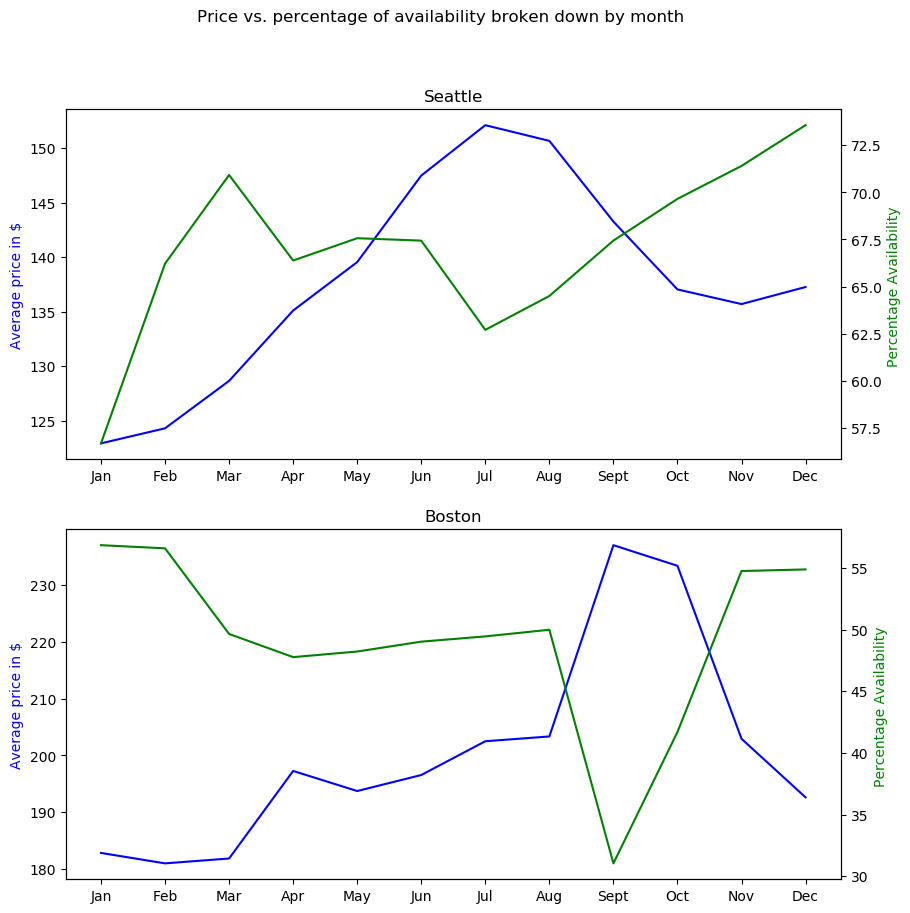

In [35]:


months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
ax = dict()
fig,(ax[0],ax[1]) = plt.subplots(2,1, figsize=(10,10))
fig.suptitle('Price vs. percentage of availability broken down by month')
for ix, city in enumerate(list_cities):
    df = df_dict[city]

    # This snippet plots two varibles on the same plot even though they have different ranges.
    # The y-axis ranges are shown on either side of the plots.
    ax[ix].set_title(city[0].upper() + city[1:])
    ax[ix].plot(months, df.groupby(['date_calendar_month'])['price_calendar_num'].mean(), color='blue')
    ax[ix].set_ylabel('Average price in $', color='blue')

    ax2=ax[ix].twinx()
    ax2.plot(months, df.groupby(['date_calendar_month'])['available_num'].mean()*100, color='green')
    ax2.set_ylabel('Percentage Availability ', color='green')

fig.savefig('price_avail_comp.png')




# 2. Do review ratings have anything to do with price?

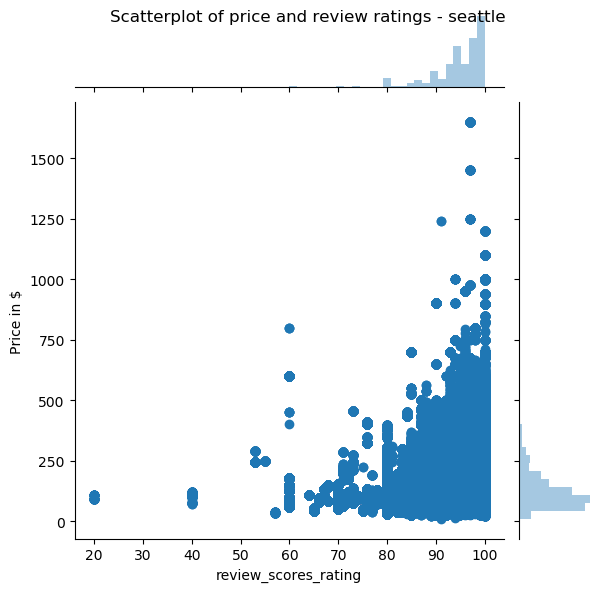

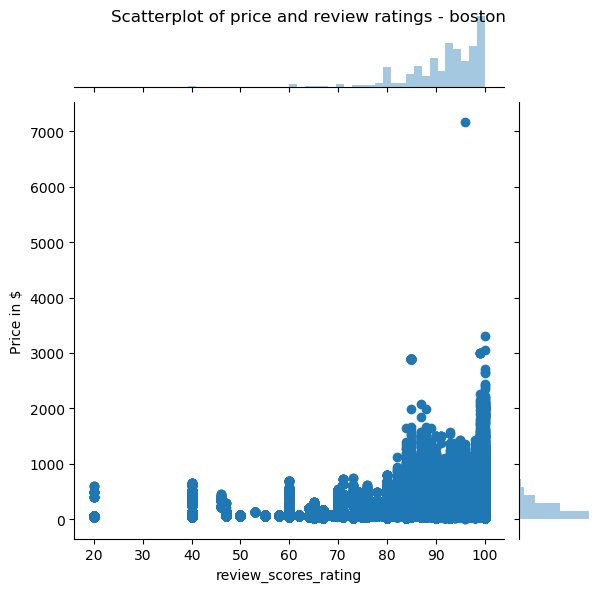

In [36]:
for ix, city in enumerate(list_cities):
    df = df_dict[city]

    f = sns.jointplot(df['review_scores_rating'], df['price_calendar_num'], kind='scatter')
    f.ax_joint.set_ylabel('Price in $')
    f.fig.suptitle('Scatterplot of price and review ratings - {}'.format(city))

    f.savefig('price_review_scatter_{}.png'.format(city))

### Break this further down to lower price ranges

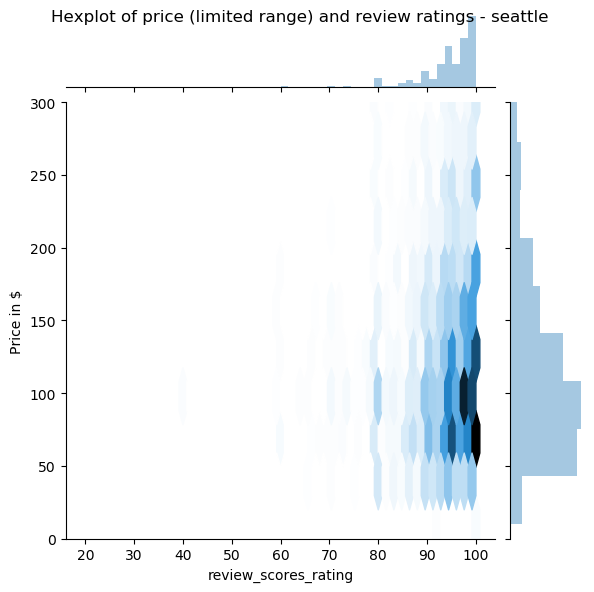

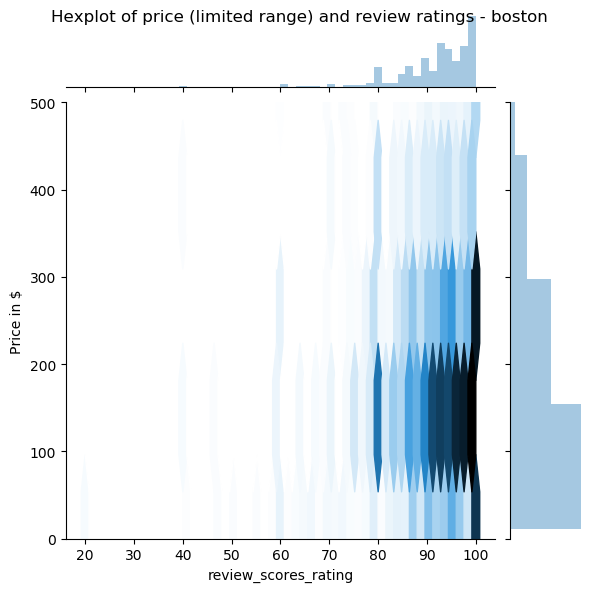

In [37]:
for ix, city in enumerate(list_cities):
    df = df_dict[city]

    # Hexplot instead
    f = sns.jointplot(df['review_scores_rating'], df['price_calendar_num'], kind='hex')
    # Limit price ranges
    if city=='seattle':
        plt.ylim(0, 300)
    else:
        plt.ylim(0, 500)
    f.ax_joint.set_ylabel('Price in $')
    f.fig.suptitle('Hexplot of price (limited range) and review ratings - {}'.format(city))

    f.savefig('price_review_hex_{}.png'.format(city))



# 3. What features are important for one to be a Superhost?

In [38]:
# Pick which city to run this analysis for
city = 'boston'
df2 = pd.read_csv('{}_airbnb/listings.csv'.format(city))

## Data preparation

In [39]:
print(df2.shape)
# Drop any rows if there is no determination if the host is a superhost. Such rows can deteriorate our classification
df2.dropna(subset=['host_is_superhost'], how='any', inplace=True)
print(df2.shape)

# Convert 't' or 'f' flags to 0 and 1 for the classifier labels.
df2.loc[df2['host_is_superhost']=='f', 'superhost'] = 0.0
df2.loc[df2['host_is_superhost']=='t', 'superhost'] = 1.0

# Convert host since to years in float
df2['host_since_diff'] = (pd.to_datetime(min(df_dict['seattle']['date'])) - pd.to_datetime(df2['host_since'])) / np.timedelta64(1, 'Y')

# reponse time is categorized.
df2 = pd.get_dummies(df2, prefix='response_time', columns=['host_response_time'], dummy_na=True)


    
# Convert host response rate to float value between 0-1
df2['host_response_rate_num'] = df2.parallel_apply(conv_resp_rate, args=('host_response_rate',), axis=1)

# Files for each city differ slightly for host_acceptance_rate.
# Seattle just has 0 and 100% and this is just converted to float.
# Boston is categorized into the individual categories.
if city=='boston':
    df2['acceptance_rate'] = df2.parallel_apply(conv_resp_rate, args=('host_acceptance_rate',), axis=1)
elif city=='seattle':
    df2 = pd.get_dummies(df2, prefix='accept', columns=['host_acceptance_rate'], dummy_na=True)

# The numbe of listings of host is converted into just whether a host has a single listing or multiple listings
df2.loc[df2['host_listings_count']==1, 'multiple_listings'] = 0.0
df2.loc[df2['host_listings_count']>1, 'multiple_listings'] = 1.0

# Flag conversion to or 1
df2.loc[df2['host_identity_verified']=='f', 'host_id_ver'] = 0.0
df2.loc[df2['host_identity_verified']=='t', 'host_id_ver'] = 1.0

# Flag conversion to or 1 - if exact location is specified by host
df2.loc[df2['is_location_exact']=='f', 'loc_exact'] = 0.0
df2.loc[df2['is_location_exact']=='t', 'loc_exact'] = 1.0

# Cleaning fee is converted to from $ string to float
df2['cleaning_fee_num'] = df2.parallel_apply(conv_num, args=('cleaning_fee',), axis=1)
# Wherever cleaning fee is null, we just take the average but individually for normal hosts and superhosts.
# This is so that we are correctly filling in the missing data instead of taking a general average.
df2.loc[(df2['cleaning_fee_num'].isnull()) & (df2['host_is_superhost']=='t'), 'cleaning_fee_num'] = np.mean(df2[df2['host_is_superhost']=='t']['cleaning_fee_num'])
df2.loc[(df2['cleaning_fee_num'].isnull()) & (df2['host_is_superhost']=='f'), 'cleaning_fee_num'] = np.mean(df2[df2['host_is_superhost']=='f']['cleaning_fee_num'])

# Categorize the cancellation policy
df2 = pd.get_dummies(df2, prefix='cancellation_policy', columns=['cancellation_policy'], dummy_na=True)

# If instantly bookable  - 0 or 1
df2.loc[df2['instant_bookable']=='f', 'inst_book'] = 0.0
df2.loc[df2['instant_bookable']=='t', 'inst_book'] = 1.0

(3585, 95)
(3585, 95)


In [40]:
# Prepare columns for the classification task

if city=='boston':
    get_cols = ['host_since_diff', 'host_response_rate_num', 'multiple_listings', 'host_id_ver', \
                'loc_exact', 'cleaning_fee_num', 'inst_book', 'acceptance_rate']

    for col in df2.columns:
        if 'response_time_' in col or 'cancellation_policy_' in col:
            get_cols.append(col)
elif city=='seattle':
    get_cols = ['host_since_diff', 'host_response_rate_num', 'multiple_listings', 'host_id_ver', \
                'loc_exact', 'cleaning_fee_num', 'inst_book']

    for col in df2.columns:
        if 'response_time_' in col or 'cancellation_policy_' in col or 'accept_' in col:
            get_cols.append(col)

print(get_cols)

['host_since_diff', 'host_response_rate_num', 'multiple_listings', 'host_id_ver', 'loc_exact', 'cleaning_fee_num', 'inst_book', 'acceptance_rate', 'response_time_a few days or more', 'response_time_within a day', 'response_time_within a few hours', 'response_time_within an hour', 'response_time_nan', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'cancellation_policy_super_strict_30', 'cancellation_policy_nan']


## Data Modeling

In [41]:
#gb = GradientBoostingClassifier(n_estimators=200, max_depth=4)
gb = XGBClassifier(n_estimators=200, max_depth=4)

# Train-test split into 67-33 split
X_train, X_test, y_train, y_test = train_test_split(df2[get_cols], df2['superhost'], test_size=0.33, random_state=42)
print(y_train.value_counts())
print(y_test.value_counts())

# Fit on train set and predict on test set
gb.fit(X_train, y_train)
preds = gb.predict(X_test)

print(len(preds), sum(preds==y_test))



0.0    2119
1.0     282
Name: superhost, dtype: int64
0.0    1059
1.0     125
Name: superhost, dtype: int64
1184 1110


In [42]:
# Ways to evaluate the detection rates and false positives.
# Can be changed based on desired metric
print(sum(y_test[y_test==1]==preds[y_test==1]))

print(sum(y_test[y_test==0]==preds[y_test==0]))

70
1040


## Get feature importances - evaluating results for question 3

In [43]:
# Get feature importances from classifier
imps = gb.feature_importances_
# Sort based on order of importance
imps_ix = np.argsort(imps)
# Flip order
imps_ix = imps_ix[::-1]
print(imps)
imps_ord = []
coefs = []
for ix in imps_ix:
    imps_ord.append(get_cols[ix])
    coefs.append(imps[ix])

[0.04973413 0.20099376 0.04426772 0.13301958 0.05167777 0.13174947
 0.04905096 0.         0.         0.07492304 0.07427429 0.04571762
 0.         0.05659302 0.03803786 0.04996077 0.         0.        ]


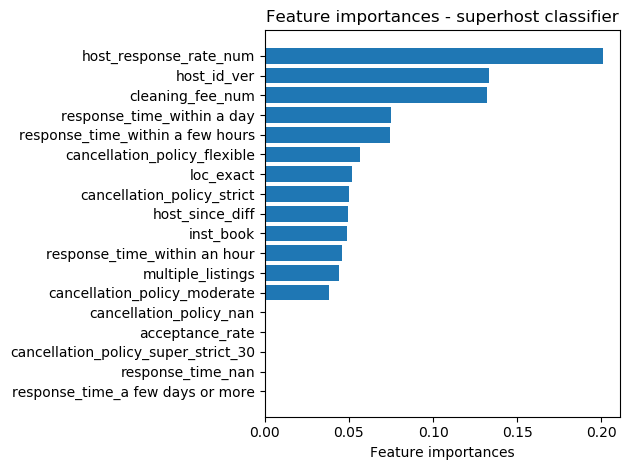

In [44]:

y_pos = np.arange(len(imps_ix))

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y_pos, coefs, align='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(imps_ord)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importances')
ax.set_title('Feature importances - superhost classifier')

plt.tight_layout()
fig.savefig('superhost_boston.png')

# Conclusion 